1.7548949999999897
[-1.75126147  1.90514233 -0.47982645  3.0779908   1.754895    0.1935517
  0.         -9.81        0.        ]
70
17
[-1.75126147  1.90514233 -0.47982645  3.0779908   1.754895    0.1935517
  0.         -9.81        0.        ]
Time for kalman filter is 0.039999961853027344 seconds
-83.77013329764753
77.31993072796826
[15.733923997038222, 16.030975079214116, 16.342686592968548, 16.670151408566387, 17.014571584187497, 17.37727203659649, 17.759716262809057, 18.16352446904816, 18.590494532791787, 19.042626307951842, 19.522149885422415, 20.031558545289815, 20.573647287546333, 21.15155801062822, 21.768832627692035, 22.42947567599052, 23.13802829176515, 23.89965579740319, 24.720251581631203, 25.60656044244194, 26.566325087180413, 27.608459998937406, 28.74325728921842, 29.982629285543176, 31.340392126052706, 32.832592984084556, 34.4778797542158, 36.297904482481634, 38.317737910058085, 40.566248187518326, 43.076356263412386, 45.885016141055765, 49.03267277944859, 52.5618227594

Text(0.5, 0, 'Height (meters)')

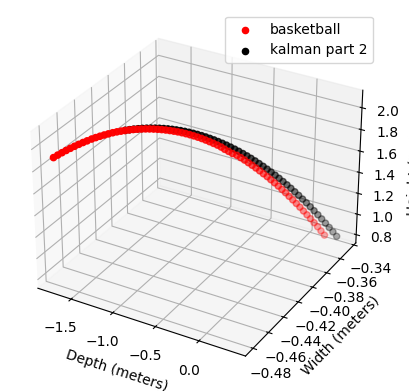

In [62]:


import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import math
import matplotlib.animation as animation
from sympy import Symbol, solve
from math import*
from pykalman import KalmanFilter


#projectile_df = pd.read_csv('projectile-basket-ball 1.csv',index_col='Frame')
time1 = time.time()
projectile_df = pd.read_csv('projectile-interception-regular 2.csv',index_col='Frame')
projectile_df = projectile_df.dropna()
basketball_x = projectile_df['TX'].values
basketball_x = basketball_x / 1000
basketball_x = basketball_x[160:230]
basketball_y = projectile_df['TZ'].values
basketball_y = basketball_y / 1000
basketball_y = basketball_y[160:230]
basketball_z = projectile_df['TY'].values
basketball_z = basketball_z / 1000
basketball_z = basketball_z[160:230]


framerate = 100 
initial_distance = basketball_y[1]-basketball_y[0]
initial_velocity = (basketball_y[1]-basketball_y[0]) * framerate 
initial_x_velocity = (basketball_x[1]-basketball_x[0]) * framerate 
initial_z_velocity = (basketball_z[1]-basketball_z[0]) * framerate 
print(initial_velocity)
#sys.exit(1)
dT = 1 / framerate
g = 9.81
#nitial_state = np.asarray([basketball_x[0],basketball_y[0],basketball_z[0],0,0,0,0,0,0])
initial_state = np.asarray([basketball_x[0],basketball_y[0],basketball_z[0],initial_x_velocity,initial_velocity,initial_z_velocity,0,-1*g,0])
print(initial_state)
transition_matrix = np.asarray(
    [
        [1., 0., 0., dT, 0., 0., 0., 0., 0.], # x pos
        [0., 1., 0., 0., dT, 0., 0., 0., 0.], # y pos
        [0., 0., 1., 0., 0., dT, 0., 0., 0.], # z pos
        [0., 0., 0., 1., 0., 0., dT, 0., 0.], # x velocity
        [0., 0., 0., 0., 1., 0., 0., dT, 0.], # y velocity
        [0., 0., 0., 0., 0., 1., 0., 0., dT], # z velocity
        [0., 0., 0., 0., 0., 0., 1., 0., 0.], # x accel
        [0., 0., 0., 0., 0., 0., 0., 1., 0.], # y accel
        [0., 0., 0., 0., 0., 0., 0., 0., 1.]  # z accel
    ]
)
observation_matrix = np.asarray(
    [
        [1, 0, 0, 0, 0, 0,0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0]
    ]
)





kf1 = KalmanFilter(transition_matrices = transition_matrix,
                  observation_matrices = observation_matrix,
                  initial_state_mean = initial_state)
measurements = []

for values in zip(basketball_x,basketball_y,basketball_z):
  measurements.append(values)


shrink_factor =4
print(len(measurements))
measurements = measurements[0::int(len(measurements)/60)]
print(len(measurements[:int(len(measurements)//shrink_factor)]))
#kf1 = kf1.em(measurements[:int(len(measurements)//shrink_factor)], n_iter=20)
print(kf1.initial_state_mean)
#sys.exit(1)
first_part = measurements[:int(len(measurements)//shrink_factor)]
(smoothed_state_means, smoothed_state_covariances) = kf1.smooth(measurements[:int(len(measurements)//shrink_factor)])
next_mean = smoothed_state_means[-1]
next_covar = smoothed_state_covariances[-1]
second_half = measurements[int(len(measurements)//shrink_factor):]
predicted_error = []
predicted_state_means = []
predicated_state_covariances = []
yaw = []
pitch = []
launcher_offset = (0,-0.1,0.1)
time_per_frame = 1/framerate
degree_speed = 191 # degrees per second
yaw_distance = []
predict_count  = 0
time_to_prediction = []
time_advantage = []
for measure in second_half:
  next_mean, next_covar = kf1.filter_update(next_mean,next_covar)
  predicted_state_means.append(next_mean)
  predicated_state_covariances.append(next_covar)
  error = next_mean[0:3] - measure
  launcher_distance = tuple(np.add(next_mean[0:3], launcher_offset))
  time_to_prediction.append(predict_count*time_per_frame)
  predict_count = predict_count + 1
  predicted_error.append(error)
  yaw.append(math.degrees(np.arctan(launcher_distance[2]/launcher_distance[0])))
  yaw_distance.append(abs(90-math.degrees(np.arctan(launcher_distance[2]/launcher_distance[0]))))
  time_advantage.append(yaw_distance[-1]/degree_speed - time_to_prediction[-1])
  #if yaw_distance[-1]/degree_speed <= time_to_prediction[-1]:
    #print(yaw_distance[-1])
   # print(yaw_distance[-1]/degree_speed)
    #print(time_to_prediction[-1])
  pitch.append(math.degrees(np.arctan(launcher_distance[1]/(np.sqrt(np.power(launcher_distance[0],2) + np.power(launcher_distance[2],2))))))
yaw_distance = np.array(yaw_distance)
time2 = time.time()
print("Time for kalman filter is " + str(time2-time1) + " seconds")
optimal_index = time_advantage.index(max(time_advantage))
optimal_yaw = yaw[optimal_index]
optimal_pitch =  pitch[optimal_index]
print(optimal_yaw)
print(optimal_pitch)
#print(predicted_error)
print(yaw)
errors = []
for coordinates in zip(smoothed_state_means[:,0:3], measurements):
  error = coordinates[0] - coordinates[1]
  errors.append(error)
#print(errors)
predicted_state_means = np.array(predicted_state_means)

# Plotting
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(basketball_x, basketball_z, basketball_y, c = 'red', label = "basketball")
#ax.scatter(smoothed_state_means[:,0],smoothed_state_means[:,2],smoothed_state_means[:,1], c="orange", label = "kalman part 1")
ax.scatter(predicted_state_means[:,0],predicted_state_means[:,2],predicted_state_means[:,1], c="black", label = "kalman part 2")
ax.legend()
ax.set_xlabel("Depth (meters)")
ax.set_ylabel("Width (meters)")
ax.set_zlabel("Height (meters)")



